This is an example of using the data loading library to draw sequences of satellite images and NWPs and also PV output values. 

I train a many-to-one LSTM network for the satellite data and the NWP data and demo how y-sequences can be drawn

In [1]:
import src
import imp
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


In [2]:
import imp
imp.reload(src.data.batch_loader)

<module 'src.data.batch_loader' from '/home/davidjamesfulton93/repos/predict_pv_yield/src/data/batch_loader.py'>

In [3]:
pv_metadata_df = src.data.load_pv.load_pv_metadata("~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_METADATA_FILEPATH)

In [4]:
pv_metadata_df.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,...,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary,x,y
system_id,,,,,,,,,,,,,,,,,,,,,
690,3.8kw of Power @ No3,3800,NaN,20,190,Phono Solar,1,4000,SMA Sunny Boy 4000,S,...,2010-12-01 00:00:00,52.087171,-0.263414,10,0,0,NaN,NaN,519080.191006,244623.301288
709,Grove Cottages,2460,RG4,12,205,Romag PowerGlaz SMT6(54)P,1,3000,SMA Sunny Boy 3000TL,SE,...,2010-09-28 00:00:00,51.485329,-0.967526,5,0,0,NaN,NaN,471786.316866,176769.072244
777,Underfell1,3420,NaN,18,190,Schuco MPE 190 MS 05,1,4000,SMA Sunny Boy 4000TL,SW,...,2010-10-29 00:00:00,54.197863,-2.938757,10,0,0,NaN,NaN,338853.840270,478417.935178
794,Roofline,3700,GU34,20,185,Sharp,1,4000,SMA,SE,...,2011-01-05 00:00:00,51.112485,-1.032715,5,0,0,NaN,NaN,467806.490433,135244.187025
973,number38,4000,WA11,16,250,Sungrid/SG250M6,1,3800,Sunny Boy 3800,SW,...,2011-01-13 00:00:00,53.467927,-2.675806,5,0,0,NaN,NaN,355234.617987,397009.685712


In [5]:
pv_power_df = src.data.load_pv.load_pv_power(filepath="~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_DATA_FILEPATH, start='2018-01-01', end='2019-12-31')

In [6]:
pv_power_df = pv_power_df.dropna(axis=0, how='all')

In [7]:
pv_power_df.head()

,690,709,794,973,1364,1556,1627,1646,1647,1872,...,68000,68212,68218,68219,68303,68324,68404,68443,68800,68846
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop systems (in-place) without PV data and metadata
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [9]:
# make clearsky GHI object
latitude, longitude = pv_metadata_df.loc[pv_power_df.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude, g0=10)

# filter data to daylight hours (in-place)
ghiscalar.filter_to_daylight(pv_power_df, min_ghi=5, inplace=True)

In [10]:
# drop rows systems with no daylight
pv_power_df = pv_power_df.dropna(axis=0, how='all')
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [11]:
# scale by max power output
rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_df = rminmax.fit_transform(pv_power_df)

In [13]:
src.data.sat_loader.AVAILABLE_CHANNELS

,description
channel_name,
VIS006,"λ_central=0.635µm, λ_min=0.56µm, λ_max=0.71µm,..."
VIS008,"λ_central=0.81µm, λ_min=0.74µm, λ_max=0.88µm, ..."
IR_016,"λ_central=1.64µm, λ_min=1.50µm, λ_max=1.78µm, ..."
IR_039,"λ_central=3.90µm, λ_min=3.48µm, λ_max=4.36µm, ..."
WV_062,"λ_central=6.25µm, λ_min=5.35µm, λ_max=7.15µm, ..."
WV_073,"λ_central=7.35µm, λ_min=6.85µm, λ_max=7.85µm, ..."
IR_087,"λ_central=8.70µm, λ_min=8.30µm, λ_max=9.1µm, |..."
IR_097,"λ_central=9.66µm, λ_min=9.38µm, λ_max=9.94µm, ..."
IR_108,"λ_central=10.80µm, λ_min=9.80µm, λ_max=11.80µm..."


In [14]:
# set up sat loader so it will return data from 4 most recent satellite images
satloader = src.data.sat_loader.SatelliteLoader(height=22000, width=22000, time_slice=[-3,-2,-1,0], channels=['HRV','IR_039','IR_108', 'IR_120'])

In [15]:
src.data.nwp_loader.AVAILABLE_CHANNELS

,description
channel_name,
t,1.5m air temperature at surface
r,1.5m Relative humidity
dpt,1.5m dew point temperature
vis,1.5m visibility
si10,10m wind speed
wdir10,10m wind direction
prmsl,Mean sea level pressure
unknown_1,Uncertain. This is likely '1.5m fog probability'
unknown_2,Uncertain. This is likely 'snow fraction'


In [16]:
# set up sat loader so it will return data from 3 most recent NWP hours and 1 hour ahead
nwploader = src.data.nwp_loader.NWPLoader(height=22000, width=22000, time_slice=[-2,-1,0,1], channels=['t', 'dswrf', 'lcc', 'mcc', 'hcc', 'r', 'prmsl'],)

Set up train and test datasets

In [13]:
# number of time-points to train on and number of systems
n_train_times = int(pv_prop_max_df.shape[0]*0.8)
n_train_systems = int(pv_prop_max_df.shape[1]*0.8)

# shuffle the systems in case they are in significant order
from sklearn.utils import shuffle 
shuffled_columns = shuffle(pv_prop_max_df.columns)
train_columns = shuffled_columns[:n_train_systems]
test_columns = shuffled_columns[n_train_systems:]

# Would be better to train on earlier data and test on later data
# however this is just an example and we have less than a year's worth of data
# therefore we'll shuffle
shuffled_times = shuffle(pv_prop_max_df.index)
train_times = shuffled_times[:n_train_times]
test_times = shuffled_times[n_train_times:]

# train set
y_train = pv_prop_max_df.reindex(index=train_times, columns=train_columns, copy=False)

# test sets
# same systems different times
y_test_time = pv_prop_max_df.reindex(index=test_times, columns=train_columns, copy=False)

# same times different systems
y_test_system = pv_prop_max_df.reindex(index=train_times, columns=test_columns, copy=False)

# different systems and different times
y_test_systemtime = pv_prop_max_df.reindex(index=test_times, columns=test_columns, copy=False)

In [14]:
y_meta_train = pv_metadata_df.reindex(y_train.columns, copy=False)

In [167]:
import imp
imp.reload(src.data.batch_loader)

<module 'src.data.batch_loader' from '/home/davidjamesfulton93/repos/predict_pv_yield/src/data/batch_loader.py'>

In [280]:
# Do some nowcasting with sat only
batch_generator = src.data.batch_loader.cross_processor_batch(
            y_train, 
            y_meta_train, 
            y_index_sequence=[0,1,2,3,4,5,6,7,8,9,10,11,12],
            max_missing_sequence_vals=4,
            clearsky=None,
            sat_loader=None,
            nwp_loader=None,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=10, 
            batches_per_superbatch=1, 
            n_superbatches=None, 
            n_epochs=1, 
            gpu=0,
            samples_per_datetime=1,
            parallel_loading_cores=1)

In [281]:
batch = next(batch_generator)

In [282]:
batch_generator.index_number

11

In [283]:
n=1
ind = batch_generator.indexes[n][0]

In [284]:
system = batch_generator.y.columns[ind[1]]
system

50659

In [285]:
dt = batch_generator.y.index[ind[0]]
dt

Timestamp('2019-02-28 10:50:00', freq='5T')

In [286]:
y = batch_generator.y.loc[dt:, system].iloc[:13]
y

2019-02-28 10:50:00    0.619133
2019-02-28 10:55:00    0.679928
2019-02-28 11:00:00    0.679928
2019-02-28 11:05:00    0.479213
2019-02-28 11:10:00         NaN
2019-02-28 11:15:00    0.220831
2019-02-28 11:20:00    0.186410
2019-02-28 11:25:00         NaN
2019-02-28 11:30:00    0.142155
2019-02-28 11:35:00    0.170317
2019-02-28 11:40:00    0.209209
2019-02-28 11:45:00    0.209209
2019-02-28 11:50:00         NaN
Freq: 5T, Name: 50659, dtype: float32

In [288]:
np.all(np.nan_to_num(batch['y'])==np.nan_to_num(y.values), axis=1)

array([ True, False, False, False, False, False, False, False, False,
       False])

In [290]:
%time batch_generator.y.interpolate(method='linear', axis=0, inplace=False, limit_direction='forward', limit_area='inside')

CPU times: user 31.6 s, sys: 1.72 s, total: 33.3 s
Wall time: 33.3 s


,49887,32961,28770,38033,22677,66250,40283,4039,26297,3074,...,11683,4670,3642,9785,56270,31707,11225,67769,11790,46959
2018-01-01 08:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:30:00,NaN,NaN,NaN,NaN,0.024590,NaN,0.001010,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.011990,NaN,0.049662,NaN,NaN,NaN
2018-01-01 08:35:00,0.002879,NaN,NaN,NaN,0.024590,NaN,0.001683,NaN,NaN,NaN,...,0.000419,NaN,NaN,NaN,0.016272,NaN,0.045964,NaN,NaN,NaN
2018-01-01 08:40:00,0.005598,NaN,NaN,NaN,0.028689,NaN,0.004712,NaN,NaN,NaN,...,0.000838,NaN,NaN,NaN,0.018556,NaN,0.043058,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-20 19:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-20 19:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-20 19:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-20 19:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
test_batch_generator = src.data.batch_loader.cross_processor_batch(
            y_test_systemtime, 
            pv_metadata_df.reindex(y_test_systemtime.columns, copy=False), 
            clearsky=None,
            sat_loader=satloader,
            nwp_loader=None,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=1000, 
            batches_per_superbatch=1, 
            n_superbatches=1, 
            n_epochs=None, 
            gpu=0,
            samples_per_datetime=1,
            parallel_loading_cores=1)

%time test_batch = next(test_batch_generator)

CPU times: user 14min 6s, sys: 2min 54s, total: 17min 1s
Wall time: 12min 33s


In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch

In [26]:
test_batch = {k:torch.from_numpy(v.astype(np.float32)) for k,v in test_batch.items()}

In [75]:
def conv_output_size(H_in, kernel_size, padding, dilation, stride):
    return int((H_in+2*padding - dilation * (kernel_size-1)-1)/stride + 1)

class ConvLSTMCell:
    def __init__(self, in_channels, conv_channels, lstm_hidden_size, kernel_size, image_side):
        self.conv2d_1 = nn.Conv2d(in_channels, conv_channels[0], kernel_size)
        self.conv2d_2 = nn.Conv2d(conv_channels[0], conv_channels[1], kernel_size)
        self.cbn_1 = nn.BatchNorm2d(conv_channels[0])        
        self.cbn_2 = nn.BatchNorm2d(conv_channels[1])
        self.activation = nn.LeakyReLU()
        self.conv_output_size = conv_output_size(
            conv_output_size(image_side, kernel_size, 0, 1, 1),
            kernel_size, 0, 1, 1)**2 * conv_channels[-1]
        self.lstm = nn.LSTMCell(self.conv_output_size+1, lstm_hidden_size)
        
    def forward(self, image, day_frac, h_0=None, c_0=None):
        x = self.conv2d_1(image)
        x = self.cbn_1(x)
        x = self.activation(x)
        
        x = self.conv2d_2(x)
        x = self.cbn_2(x)
        x = self.activation(x)
        
        x = x.view(x.shape[0], -1)
        x = torch.cat([x, day_frac.view(-1,1)], dim=1)
        
        if h_0 is None and c_0 is None:
            h, c = self.lstm(x)
        else:
            h, c = self.lstm(x, (h_0, c_0))
        return h, c

        
class ConvLSTM(nn.Module):
    def __init__(self, in_channels, conv_channels, lstm_hidden_size, kernel_size, image_side):
        super().__init__()
        self.conv_lstm_cell = ConvLSTMCell(in_channels, conv_channels, lstm_hidden_size, 
                                           kernel_size, image_side)
        self.fc = nn.Linear(lstm_hidden_size, 1)
        
    def forward(self, image, day_frac):
        for i in range(image.shape[-1]):
            if i==0:
                h, c = self.conv_lstm_cell.forward(image[...,i], day_frac)
            else:
                h, c = self.conv_lstm_cell.forward(image[...,i], day_frac, h, c)
        x = self.fc(h)
        x = F.relu(x)
        return x

In [80]:
sat_net = ConvLSTM(
    in_channels=4, 
    conv_channels=[4,4], 
    lstm_hidden_size=10, 
    kernel_size=5, 
    image_side=11)

loss_func = nn.MSELoss()
mae_loss_func = nn.L1Loss()
optimizer = optim.SGD(sat_net.parameters(), lr=0.01, momentum=0.8)

train_losses = []
train_mae_losses = []
test_losses = []
test_mae_losses = []

In [81]:
STATS_PERIOD = 100

In [83]:
# Set to zero if continuing or set to -1 to load new batch.
# In general you don't need to do this, just a hack for this notebook.
batch_generator.batch_index = 0

t0 = time.time()

shuffles_per_superbatch = 5
current_shuffles = 1


running_train_loss = 0.0
running_train_mae = 0.0

for i_batch, batch in enumerate(batch_generator):
    
    batch = {k:torch.from_numpy(v.astype(np.float32)) for k,v in batch.items()}

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    sat_net.train()
    outputs = sat_net(batch['satellite'], batch['day_fraction'])
    train_loss = loss_func(outputs, batch['y'])
    train_loss.backward()
    optimizer.step()
    running_train_loss += train_loss.item()

    # MAE
    train_mae = mae_loss_func(outputs, batch['y'])
    running_train_mae += train_mae.item()

    # print statistics
    if i_batch == 0 or i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches
        print('\rBatch: {:4d}'.format(i_batch))
        t1 = time.time()

        # Train loss
        if i_batch == 0:
            mean_train_loss = running_train_loss
            mean_train_mae = running_train_mae
        else:
            mean_train_loss = running_train_loss / STATS_PERIOD
            mean_train_mae = running_train_mae / STATS_PERIOD

        train_losses.append(mean_train_loss)
        train_mae_losses.append(mean_train_mae)

        # Test loss
        sat_net.eval()
        test_outputs = sat_net(test_batch['satellite'], test_batch['day_fraction'])
        test_loss = loss_func(test_outputs, test_batch['y']).item()
        test_losses.append(test_loss)
        test_mae = mae_loss_func(test_outputs, test_batch['y']).item()
        test_mae_losses.append(test_mae)

        print(
            '\n        time =   {:.2f} milli seconds training per batch.\n'
            '   train loss = {:8.5f}\n'
            '    train MAE = {:8.5f}\n'
            '    test loss = {:8.5f}\n'
            '     test MAE = {:8.5f}\n'.format(
                ((t1 - t0) / STATS_PERIOD) * 1000,
                mean_train_loss, 
                mean_train_mae,
                test_loss,
                test_mae
            ))
        print('Proportion zeros : {}'.format(((test_outputs==0)*1.).mean()))
        
        running_train_loss = 0.0
        running_train_mae = 0.0
        t0 = time.time()
        
    # if we have got to end of superbatch reshuffle
    if batch_generator.batch_index==(batch_generator.batches_per_superbatch-1):
        # but only if we haven't already shuffled so mnay times
        if current_shuffles < shuffles_per_superbatch:
            print('reshuffling super-batch')
            batch_generator.shuffle_cpu_superbatch()
            if batch_generator.gpu: batch_generator.transfer_superbatch_to_gpu()
            batch_generator.batch_index = 0
            current_shuffles+=1
        # if we have shiuffled our limit of times then update shuffle tally
        elif current_shuffles >= shuffles_per_superbatch:
            print('reshuffled this super-batch too many times. Loading new.')
            current_shuffles = 1


print('\nFinished Training')

Batch:    0

        time =   0.39 milli seconds training per batch.
   train loss =  0.08096
    train MAE =  0.24910
    test loss =  0.08229
     test MAE =  0.23300

Proportion zeros : 0.0
reshuffling super-batch
Batch:   99

        time =   36.44 milli seconds training per batch.
   train loss =  0.08383
    train MAE =  0.23868
    test loss =  0.07766
     test MAE =  0.22804

Proportion zeros : 0.0
reshuffling super-batch
Batch:  199

        time =   36.96 milli seconds training per batch.
   train loss =  0.08080
    train MAE =  0.23698
    test loss =  0.07150
     test MAE =  0.22190

Proportion zeros : 0.0
reshuffling super-batch
Batch:  299

        time =   36.71 milli seconds training per batch.
   train loss =  0.07916
    train MAE =  0.23456
    test loss =  0.06973
     test MAE =  0.21750

Proportion zeros : 0.0
reshuffling super-batch
Batch:  399

        time =   36.67 milli seconds training per batch.
   train loss =  0.07871
    train MAE =  0.23340
    test 

KeyboardInterrupt: 

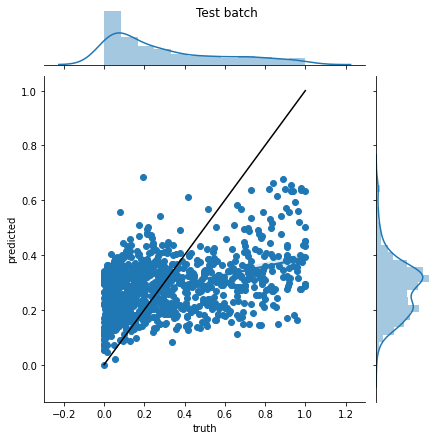

In [46]:
y = test_outputs.cpu().detach().numpy().flatten()
x = test_batch['y'].cpu().detach().numpy().flatten()
c = None

g = sns.jointplot(x, y, kind='reg', scatter = False)
g.ax_joint.scatter(x, y, c=c)
g.ax_joint.plot([0,1], [0,1], color='k')
g.set_axis_labels(xlabel='truth', ylabel='predicted')
g.fig.suptitle('Test batch')
plt.show()

In [135]:
batch_generator = src.data.batch_loader.cross_processor_batch(
            y_train, 
            y_meta_train, 
            clearsky=None,
            sat_loader=None,
            nwp_loader=nwploader,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=256, 
            batches_per_superbatch=100, 
            n_superbatches=None, 
            n_epochs=1, 
            gpu=0,
            samples_per_datetime=100,
            parallel_loading_cores=1)

In [100]:
test_batch_generator = src.data.batch_loader.cross_processor_batch(
            y_test_systemtime, 
            pv_metadata_df.reindex(y_test_systemtime.columns, copy=False), 
            clearsky=None,
            sat_loader=None,
            nwp_loader=nwploader,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=1000, 
            batches_per_superbatch=1, 
            n_superbatches=1, 
            n_epochs=None, 
            gpu=0,
            samples_per_datetime=1,
            parallel_loading_cores=1)

%time test_batch = next(test_batch_generator)

CPU times: user 25min 35s, sys: 2min 20s, total: 27min 56s
Wall time: 18min 13s


In [104]:
test_batch = {k:torch.from_numpy(v.astype(np.float32)) for k,v in test_batch.items()}

In [136]:
nwp_net = ConvLSTM(
    in_channels=7, 
    conv_channels=[20,20], 
    lstm_hidden_size=10,
    kernel_size=5, 
    image_side=11)

loss_func = nn.MSELoss()
mae_loss_func = nn.L1Loss()
optimizer = optim.SGD(nwp_net.parameters(), lr=0.01, momentum=0.8)

train_losses = []
train_mae_losses = []
test_losses = []
test_mae_losses = []

In [137]:
# Set to zero if continuing or set to -1 to load new batch.
# In general you don't need to do this, just a hack for this notebook.
batch_generator.batch_index = -1

t0 = time.time()

shuffles_per_superbatch = 5
current_shuffles = 1


running_train_loss = 0.0
running_train_mae = 0.0

for i_batch, batch in enumerate(batch_generator):
    
    batch = {k:torch.from_numpy(v.astype(np.float32)) for k,v in batch.items()}

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    nwp_net.train()
    outputs = nwp_net(batch['nwp'], batch['day_fraction'])
    train_loss = loss_func(outputs, batch['y'])
    train_loss.backward()
    optimizer.step()
    running_train_loss += train_loss.item()

    # MAE
    train_mae = mae_loss_func(outputs, batch['y'])
    running_train_mae += train_mae.item()

    # print statistics
    if i_batch == 0 or i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches
        print('\rBatch: {:4d}'.format(i_batch))
        t1 = time.time()

        # Train loss
        if i_batch == 0:
            mean_train_loss = running_train_loss
            mean_train_mae = running_train_mae
        else:
            mean_train_loss = running_train_loss / STATS_PERIOD
            mean_train_mae = running_train_mae / STATS_PERIOD

        train_losses.append(mean_train_loss)
        train_mae_losses.append(mean_train_mae)

        # Test loss
        nwp_net.eval()
        test_outputs = nwp_net(test_batch['nwp'], test_batch['day_fraction'])
        test_loss = loss_func(test_outputs, test_batch['y']).item()
        test_losses.append(test_loss)
        test_mae = mae_loss_func(test_outputs, test_batch['y']).item()
        test_mae_losses.append(test_mae)

        print(
            '\n        time =   {:.2f} milli seconds training per batch.\n'
            '   train loss = {:8.5f}\n'
            '    train MAE = {:8.5f}\n'
            '    test loss = {:8.5f}\n'
            '     test MAE = {:8.5f}\n'.format(
                ((t1 - t0) / STATS_PERIOD) * 1000,
                mean_train_loss, 
                mean_train_mae,
                test_loss,
                test_mae
            ))
        print('Proportion zeros : {}'.format(((test_outputs==0)*1.).mean()))
        
        running_train_loss = 0.0
        running_train_mae = 0.0
        t0 = time.time()
        
    # if we have got to end of superbatch reshuffle
    if batch_generator.batch_index==(batch_generator.batches_per_superbatch-1):
        # but only if we haven't already shuffled so mnay times
        if current_shuffles < shuffles_per_superbatch:
            print('reshuffling super-batch')
            batch_generator.shuffle_cpu_superbatch()
            if batch_generator.gpu: batch_generator.transfer_superbatch_to_gpu()
            batch_generator.batch_index = 0
            current_shuffles+=1
        # if we have shiuffled our limit of times then update shuffle tally
        elif current_shuffles >= shuffles_per_superbatch:
            print('reshuffled this super-batch too many times. Loading new.')
            current_shuffles = 1


print('\nFinished Training')

Batch:    0

        time =   4440.54 milli seconds training per batch.
   train loss =  0.14173
    train MAE =  0.27248
    test loss =  0.13378
     test MAE =  0.25550

Proportion zeros : 0.41600000858306885
Batch:   99

        time =   67.97 milli seconds training per batch.
   train loss =  0.07717
    train MAE =  0.21028
    test loss =  0.05715
     test MAE =  0.18990

Proportion zeros : 0.05400000140070915
reshuffling super-batch
reshuffling super-batch
Batch:  199

        time =   74.20 milli seconds training per batch.
   train loss =  0.05409
    train MAE =  0.18185
    test loss =  0.05231
     test MAE =  0.18165

Proportion zeros : 0.032999999821186066
reshuffling super-batch
Batch:  299

        time =   72.14 milli seconds training per batch.
   train loss =  0.05170
    train MAE =  0.17777
    test loss =  0.05151
     test MAE =  0.18026

Proportion zeros : 0.023000000044703484
reshuffling super-batch
Batch:  399

        time =   72.53 milli seconds training p

KeyboardInterrupt: 

### Drawing y-sequences

Below we use the `y_index_sequence` parameter to draw y values forwards from a randomly sampled time. 

Selecting `y_index_sequence=[i0,i1,i2]` gives us PV sequences at times `T+i0*5mins`, `T+i1*5mins` and `T+i2*5mins` where `T` is a randomly selected start time in our sample.

Below we select hour long sequences `T+{0-60mins}`.

Note that selecting sequences means that the batch_generator takes longer to instantiate

In [15]:
batch_generator = src.data.batch_loader.cross_processor_batch(
            y_train, 
            y_meta_train, 
            y_index_sequence=[0,1,2,3,4,5,6,7,8,9,10,11,12],
            max_missing_sequence_vals=0,
            clearsky=None,
            sat_loader=None,
            nwp_loader=None,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=100, 
            batches_per_superbatch=1, 
            n_superbatches=None, 
            n_epochs=1, 
            gpu=0,
            samples_per_datetime=1,
            parallel_loading_cores=1)

In [16]:
batch = next(batch_generator)

In [20]:
pv_sequences = batch['y']
pv_sequences

array([[0.3769617 , 0.3769617 , 0.3769617 , ..., 0.3289391 , 0.3289391 ,
        0.40332705],
       [0.26271185, 0.26468927, 0.25451976, ..., 0.20028248, 0.17090395,
        0.16440678],
       [0.17007299, 0.19452555, 0.20474453, ..., 0.1569343 , 0.15620437,
        0.1459854 ],
       ...,
       [0.01338432, 0.04206501, 0.0446144 , ..., 0.08731676, 0.10197578,
        0.0707457 ],
       [0.1486175 , 0.17396313, 0.20794931, ..., 0.28974655, 0.24193548,
        0.24193548],
       [0.04365079, 0.04365079, 0.04761905, ..., 0.01984127, 0.01190476,
        0.00793651]], dtype=float32)

In [21]:
pv_sequences[0]

array([0.3769617 , 0.3769617 , 0.3769617 , 0.29817954, 0.29817954,
       0.29817954, 0.30947897, 0.30947897, 0.30947897, 0.3289391 ,
       0.3289391 , 0.3289391 , 0.40332705], dtype=float32)

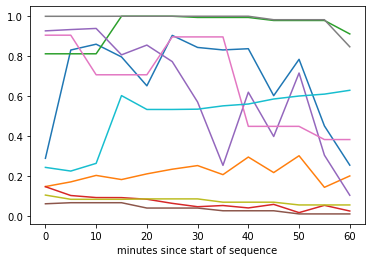

In [32]:
plt.plot(np.arange(0, 65, 5), pv_sequences[10:20].T)
plt.xlabel('minutes since start of sequence')
plt.show()